# Transfer learning

Set the environment (for Google Colab):

If this is GoogleColab we download config and use it to download necesseary folders and files for this project (defined in `config.py`). Here we'll need:
- `pytorched.step_by_step.py`
- `data_preparation.rps.py`

In [ ]:
#|code-fold: true
#|output: false
try:
    import google.colab
    !pip install numpy pandas matplotlib torchviz scikit-learn tensorboard torchvision torch tqdm torch-lr-finder

    import requests
    url = 'https://raw.githubusercontent.com/nesaboz/pytorched/main/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    print('Not Google Colab environment.')


from config import config_project
config_project('transfer_learning')

Not Google Colab environment.


We are now ready for imports:

In [ ]:
#|code-fold: true
#|output: false
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop, InterpolationMode
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
from torchvision.models.alexnet import model_urls
from torchvision.models import Inception_V3_Weights, AlexNet_Weights
from torch.hub import load_state_dict_from_url
from torchviz import make_dot

from data_generation.rps import download_rps
from pytorched.step_by_step import StepByStep, freeze_model, print_trainable_parameters

plt.style.use('fivethirtyeight')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# AlexNet

Let's try to use AlexNet model first to help us in the Rock-Paper-Scissors problem. We'll need to load AlexNet, with it's weights, then make a feature-extractor on our data loaders, modify the last layer, and train. Let's get to it: 

We can get AlexNet from torchvision.models:

In [ ]:
weights = AlexNet_Weights.IMAGENET1K_V1
alex = alexnet(weights=weights)
alex

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We need an original transform:

In [ ]:
transform = weights.transforms()

Let's now create new data loaders based on this transform:


In [ ]:
#|code-fold: true 
#|output: false
download_rps()

rps folder already exists!
rps-test-set folder already exists!


In [ ]:
train_dataset = ImageFolder(root='rps', transform=transform)
val_dataset = ImageFolder(root='rps-test-set', transform=transform)

In [ ]:
train_loader = DataLoader(train_dataset, 16, shuffle=True)
val_loader = DataLoader(val_dataset, 16)

Let's also define an optimizer and loss:

In [ ]:
torch.manual_seed(17)
optimizer = optim.Adam(alex.parameters(), 3e-4)
loss_fn = nn.CrossEntropyLoss()
sbs = StepByStep(alex, optimizer, loss_fn)
sbs.set_loaders(train_loader, val_loader)

# Feature-extractor


These are current trainable parameters:

In [ ]:
sbs.print_trainable_parameters()

features.0.weight
features.0.bias
features.3.weight
features.3.bias
features.6.weight
features.6.bias
features.8.weight
features.8.bias
features.10.weight
features.10.bias
classifier.1.weight
classifier.1.bias
classifier.4.weight
classifier.4.bias
classifier.6.weight
classifier.6.bias


We must freeze the model and replace the last layer. These are suggestions what layers to change (of course more layers can be left unfrozen but this requires more training data and longer times):

<img id="transfer_learning_layer_replacement" src="images/transfer_learning_layer_replacement.jpg"/>

so let's change the last layer first to Identity to make feature extractor:

In [ ]:
sbs.model.classifier[6] = nn.Identity()

In [ ]:
freeze_model(sbs.model)

In [ ]:
sbs.print_trainable_parameters()

No trainable parameters.


We now go throught the loader batch by batch and pass the data through the model in order to generate new preprocessed datasets: 

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def preprocessed_dataset(model, loader, device=None):
    """
    Runs all data in the loader through the model and returns a dataset.
    """
    
    features = torch.Tensor()
    labels = torch.Tensor().type(torch.long)

    if device is None:
        device = next(model.parameters()).device

    for i, (x_batch, y_batch) in enumerate(loader):
        model.eval()
        output = model(x_batch.to(device))
        features = torch.cat([features, output.detach().cpu()])
        labels = torch.cat([labels, y_batch.cpu()])

    return TensorDataset(features, labels)

In [ ]:
def test_preprocessed_dataset():
    x = torch.rand(10,3,244,244)
    y = torch.rand(10,1)
    ds = TensorDataset(x,y)
    dl = DataLoader(ds, 16, False)
    tpp = preprocessed_dataset(alex, dl)
    assert tpp.tensors[0].shape == torch.Size([10, 4096])

In [ ]:
train_preproc = preprocessed_dataset(alex, train_loader)
val_preproc = preprocessed_dataset(alex, val_loader)

make sure that the tensort types are correct:

In [ ]:
assert next(iter(train_preproc))[0].type() == 'torch.FloatTensor'
assert next(iter(train_preproc))[1].type() == 'torch.LongTensor' 

we now build new DataLoaders:

In [ ]:
new_train_loader = DataLoader(train_preproc, 16, True)
new_val_loader = DataLoader(val_preproc, 16)

# Top layer

With features extracted we can now create a brand new simple model using a fully-connected layer [per table](#transfer_learning_layer_replacement) suggestions `nn.Linear(4096, num_classes)`:

Let's create a new model:

In [ ]:
torch.manual_seed(17)
top_layer = nn.Linear(4096, 3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(top_layer.parameters(), lr=3e-4)
sbs_top = StepByStep(top_layer, optimizer_top, multi_loss_fn)
sbs_top.set_loaders(new_train_loader, new_val_loader)

In [ ]:
sbs_top.train(10)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  8.21it/s]


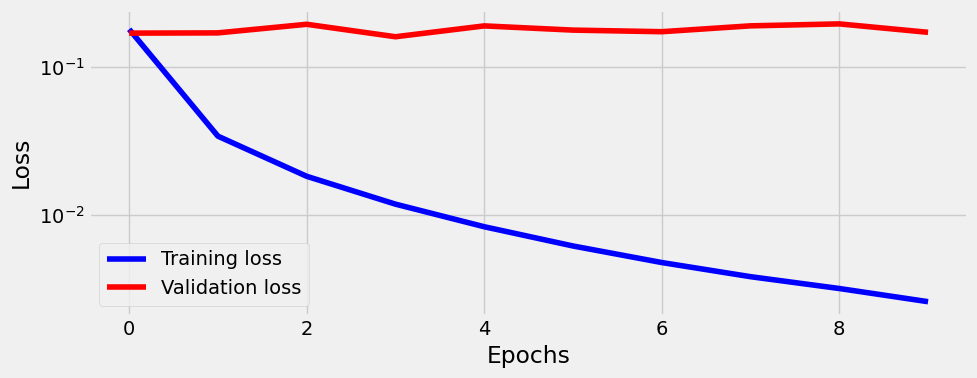

In [ ]:
_ = sbs_top.plot_losses()

In [ ]:
sbs_top.accuracy

95.97

In [ ]:
sbs_top.accuracy_per_class

tensor([[109, 124],
        [124, 124],
        [124, 124]])

And this is pretty good, and very fast too!

For any new images that need to be evaluated thought, we will have to go through the whole model, so let's insert this new `top_layer` into a `sbs`. **Important: be very careful when changing the model layers AFTER creating StepByStep object. Model change that changes parameters must be reflected in optimizer as well (I added some check for this via `sbs.check_consistency` that checks number of parameters).** 

In [ ]:
sbs.model.classifier[6] = top_layer
sbs.check_consistency()
sbs.model.classifier

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=3, bias=True)
)

Let's evaluate on the old `val_loader` to see if we get the same result:

In [ ]:
sbs.accuracy_per_class

tensor([[109, 124],
        [124, 124],
        [124, 124]])

In [ ]:
sbs.accuracy

95.97

yup, exactly the same.

# Inception Model

Let's try Inception model. Inception has these [2 layers](#session_rate) so we can not run the feature extraction, we have to use the full model. First we prep the data:

In [ ]:
weights = Inception_V3_Weights.IMAGENET1K_V1
transform = weights.transforms()
train_dataset = ImageFolder(root='rps', transform=transform)
val_dataset = ImageFolder(root='rps-test-set', transform=transform)
train_loader = DataLoader(train_dataset, 16, True)
val_loader = DataLoader(val_dataset, 16)

In [ ]:
transform

ImageClassification(
    crop_size=[299]
    resize_size=[342]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

next we set the model and freeze it:

In [ ]:
inception = inception_v3(weights=weights)
freeze_model(inception)
print_trainable_parameters(inception)

No trainable parameters.


replace the top layers per advice:

In [ ]:
inception.fc = nn.Linear(2048, 3)
inception.AuxLogits.fc = nn.Linear(768, 3)
print_trainable_parameters(inception)

AuxLogits.fc.weight
AuxLogits.fc.bias
fc.weight
fc.bias


We need to create special loss function that handles 2 output losses (one main and one auxilary) and combines them (with weight of 0.4 for auxilary):

In [ ]:
def inception_loss(outputs, labels):
    try:
        main, aux = outputs  # this is a KEY difference from other models with single output
    except ValueError:
        main, aux = outputs, None  # this is a typical loss with no auxilairy layers
        
    main_loss = nn.CrossEntropyLoss()(main, labels)
    aux_loss = nn.CrossEntropyLoss()(aux, labels) if aux is not None else 0
    return main_loss + 0.4 * aux_loss

We are now ready to create `sbs` object:

In [ ]:
torch.manual_seed(17)
optimizer = optim.Adam(inception.parameters(), lr=3e-4)
sbs_inception = StepByStep(inception, optimizer, inception_loss)
sbs_inception.set_loaders(train_loader, val_loader)

It is training time:

In [ ]:
sbs_inception.train(5)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [08:06<00:00, 486.61s/it]


In [ ]:
print(sbs_inception.accuracy_per_class)
print(sbs_inception.accuracy)
sbs_inception.plot_losses()

tensor([[ 93, 124],
        [ 55, 124],
        [  0, 124]])

# Batch normalization

TODO